# SageNet

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 10.01.2023
- **Date of Last Modification:** 17.08.2023

- The SageNet source code is available at https://github.com/MarioniLab/SageNet.
- The corresponding preprint is "Heidari, E. et al. Supervised spatial inference of dissociated single-cell data with SageNet. bioRxiv 2022.04.14.488419 (2022) doi:10.1101/2022.04.14.488419".
- Parts of the workflow of this notebook are inspired by the tutorial from https://scarches.readthedocs.io/en/latest/SageNet_mouse_embryo.html.
- The SageNet authors recommend log normalized counts as input. Therefore, we use log normalized counts (stored in adata.X).

## 1. Setup

### 1.1 Import Libraries

In [1]:
import copy
import os
import random
import time
from datetime import datetime

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scarches as sca
import scanpy as sc
import scipy.sparse as sp
import squidpy as sq
import torch
import torch_geometric.data as geo_dt
from scarches.models.sagenet.utils import glasso

[rank: 0] Global seed set to 0
/home/aih/sebastian.birk/.local/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/aih/sebastian.birk/.local/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


### 1.2 Define Parameters

In [2]:
model_name = "sagenet"
latent_key = f"{model_name}_latent"
leiden_resolution = 0.5 # used for Leiden clustering of latent space
random_seed = 0 # used for Leiden clustering

### 1.3 Run Notebook Setup

In [3]:
sc.set_figure_params(figsize=(6, 6))

In [4]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [5]:
# Use GPU if available
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print(device)

cuda:0


### 1.4 Configure Paths and Directories

In [6]:
data_folder_path = "../../datasets/srt_data/gold/"
benchmarking_folder_path = "../../artifacts/single_sample_method_benchmarking"
figure_folder_path = f"../../figures"

## 2. SageNet Model

### 2.1 Define Training Function

In [7]:
def train_sagenet_models(dataset,
                         cell_type_key,
                         adata_new=None,
                         n_start_run=1,
                         n_end_run=8,
                         n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16],
                         plot_latent_umaps: bool=False):
    # Configure figure folder path
    dataset_figure_folder_path = f"{figure_folder_path}/{dataset}/method_benchmarking/" \
                                 f"{model_name}/{current_timestamp}"
    os.makedirs(dataset_figure_folder_path, exist_ok=True)
    
    # Create new adata to store results from training runs in storage-efficient way
    if adata_new is None:
        adata_original = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
        adata_new = sc.AnnData(sp.csr_matrix(
            (adata_original.shape[0], adata_original.shape[1]),
            dtype=np.float32))
        adata_new.var_names = adata_original.var_names
        adata_new.obs_names = adata_original.obs_names
        adata_new.obs["cell_type"] = adata_original.obs[cell_type_key].values
        adata_new.obsm["spatial"] = adata_original.obsm["spatial"]
        del(adata_original)
    
    for run_number, n_neighbors in zip(np.arange(n_start_run, n_end_run+1), n_neighbor_list):
        # Load data
        adata = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
        
        adata.X = adata.X.toarray()
        
        # Compute spatial neighborhood graph for clustering
        sq.gr.spatial_neighbors(adata,
                                coord_type="generic",
                                spatial_key="spatial",
                                n_neighs=n_neighbors)
        
        start_time = time.time()

        # Estimate gene interaction network
        glasso(adata, [0.25, 0.5]) # the adjacency matrix of the built graph is added under 'adata.varm["adj"]'

        # Compute spatial partitoning with 3 different resolutions to capture different granularities
        sc.tl.leiden(adata,
                     resolution=.05,
                     random_state=random_seed,
                     key_added="leiden_0.05",
                     adjacency=adata.obsp["spatial_connectivities"]) # the partitioning is added under 'adata.obs["leiden_0.05"]'
        sc.tl.leiden(adata,
                     resolution=.1,
                     random_state=random_seed,
                     key_added="leiden_0.1",
                     adjacency=adata.obsp["spatial_connectivities"]) # the partitioning is added under 'adata.obs["leiden_0.1"]'
        sc.tl.leiden(adata,
                     resolution=.5,
                     random_state=random_seed,
                     key_added="leiden_0.5",
                     adjacency=adata.obsp["spatial_connectivities"]) # the partitioning is added under 'adata.obs["leiden_0.5"]'
        sc.pl.spatial(adata,
                      color=["leiden_0.05", "leiden_0.1", "leiden_0.5"],
                      frameon=False,
                      ncols=3,
                      spot_size=.1,
                      title=["leiden_0.05", "leiden_0.1", "leiden_0.5"],
                      legend_loc=None)

        # Define model object
        sg_obj = sca.models.sagenet(device=device)

        sg_obj.train(adata,
                     comm_columns=["leiden_0.05", "leiden_0.1", "leiden_0.5"],
                     tag="batch1",
                     epochs=15,
                     verbose=False,
                     importance=True)

        sg_obj.load_query_data(adata)
        
        # Measure time for model training
        end_time = time.time()
        elapsed_time = end_time - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"Duration of model training in run {run_number}: "
              f"{int(hours)} hours, {int(minutes)} minutes and {int(seconds)} seconds.")
        adata_new.uns[f"{model_name}_model_training_duration_run{run_number}"] = (
            elapsed_time)

        # Use SageNet cell-cell-distances for UMAP generation
        sc.pp.neighbors(adata,
                        use_rep="dist_map",
                        n_neighbors=n_neighbors)
        sc.tl.umap(adata)
        
        if plot_latent_umaps:
            fig = sc.pl.umap(adata,
                             color=[cell_type_key],
                             title="Latent Space with Cell Types: SageNet",
                             return_fig=True)
            fig.savefig(f"{dataset_figure_folder_path}/latent_{model_name}"
                        f"_cell_types_run{run_number}.png",
                        bbox_inches="tight")

            # Compute latent Leiden clustering
            sc.tl.leiden(adata=adata,
                         resolution=leiden_resolution,
                         random_state=random_seed,
                         key_added=f"latent_{model_name}_leiden_{str(leiden_resolution)}")

            # Create subplot of latent Leiden cluster annotations in physical and latent space
            fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
            title = fig.suptitle(t="Latent and Physical Space with Leiden Clusters: SageNet")
            sc.pl.umap(adata=adata,
                       color=[f"latent_{model_name}_leiden_{str(leiden_resolution)}"],
                       title=f"Latent Space with Leiden Clusters",
                       ax=axs[0],
                       show=False)
            sq.pl.spatial_scatter(adata=adata,
                                  color=[f"latent_{model_name}_leiden_{str(leiden_resolution)}"],
                                  title=f"Physical Space with Leiden Clusters",
                                  shape=None,
                                  ax=axs[1])

            # Create and position shared legend
            handles, labels = axs[0].get_legend_handles_labels()
            lgd = fig.legend(handles, labels, bbox_to_anchor=(1.25, 0.9185))
            axs[0].get_legend().remove()
            axs[1].get_legend().remove()

            # Adjust, save and display plot
            plt.subplots_adjust(wspace=0, hspace=0.2)
            fig.savefig(f"{dataset_figure_folder_path}/latent_physical_comparison_"
                        f"{model_name}_run{run_number}.png",
                        bbox_extra_artists=(lgd, title),
                        bbox_inches="tight")
            plt.show()

        # Use UMAP embedding of cell-cell distances as latent features
        adata_new.obsm[latent_key + f"_run{run_number}"] = adata.obsm["X_umap"]

        # Store intermediate adata to disk
        adata_new.write(f"{benchmarking_folder_path}/{dataset}_{model_name}.h5ad")

    # Store final adata to disk
    adata_new.write(f"{benchmarking_folder_path}/{dataset}_{model_name}.h5ad")  

### 2.2 Train Models on Benchmarking Datasets

In [ ]:
train_sagenet_models(dataset="seqfish_mouse_organogenesis_embryo2",
                     cell_type_key="celltype_mapped_refined",
                     adata_new=None,
                     n_start_run=1,
                     n_end_run=8,
                     n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16])

In [ ]:
for subsample_pct in [50, 25, 10, 5, 1]:
    train_sagenet_models(dataset=f"seqfish_mouse_organogenesis_subsample_{subsample_pct}pct_embryo2",
                         cell_type_key="celltype_mapped_refined",
                         adata_new=None,
                         n_start_run=1,
                         n_end_run=8,
                         n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16])

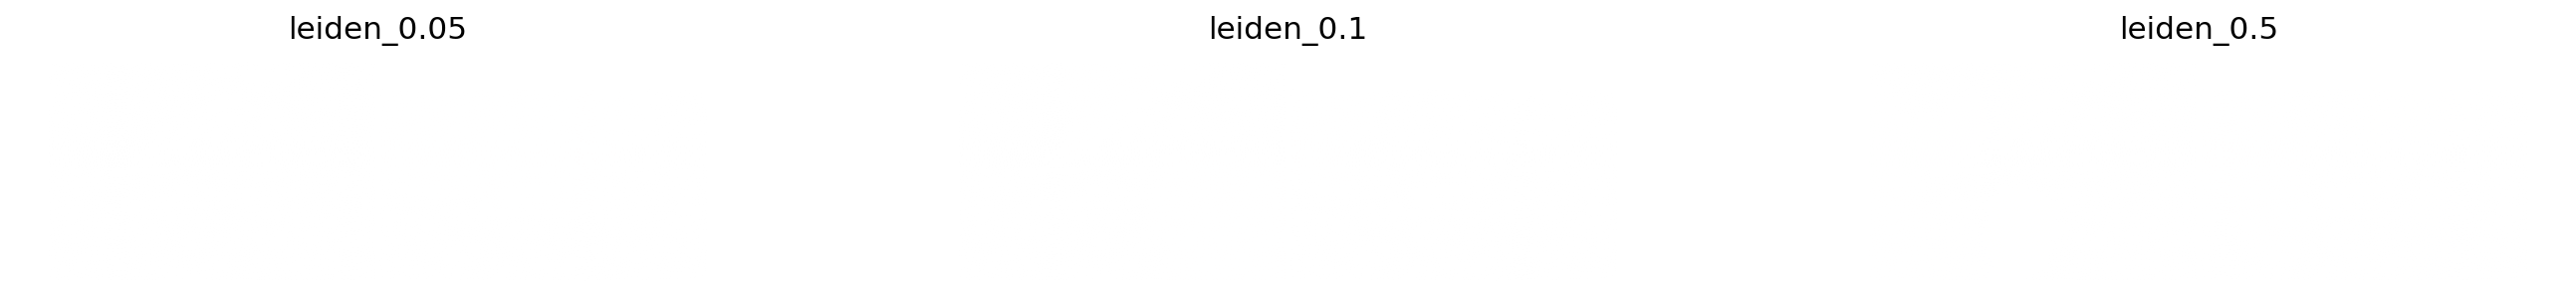

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 1: 0 hours, 2 minutes and 40 seconds.


/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/h

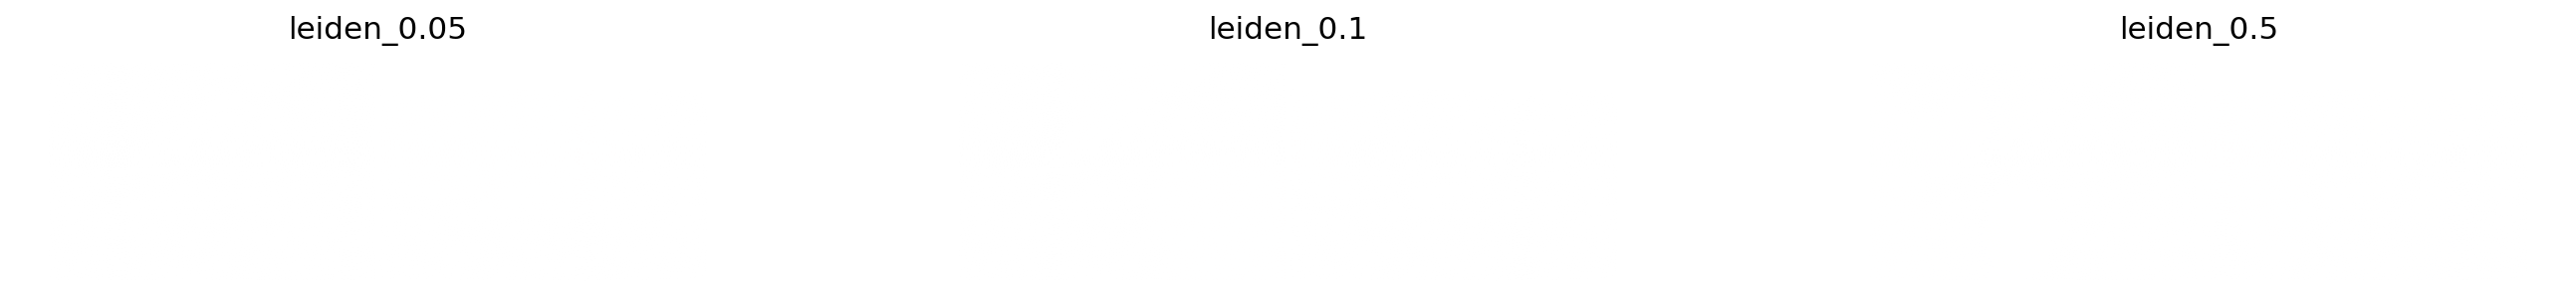

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 2: 0 hours, 2 minutes and 33 seconds.


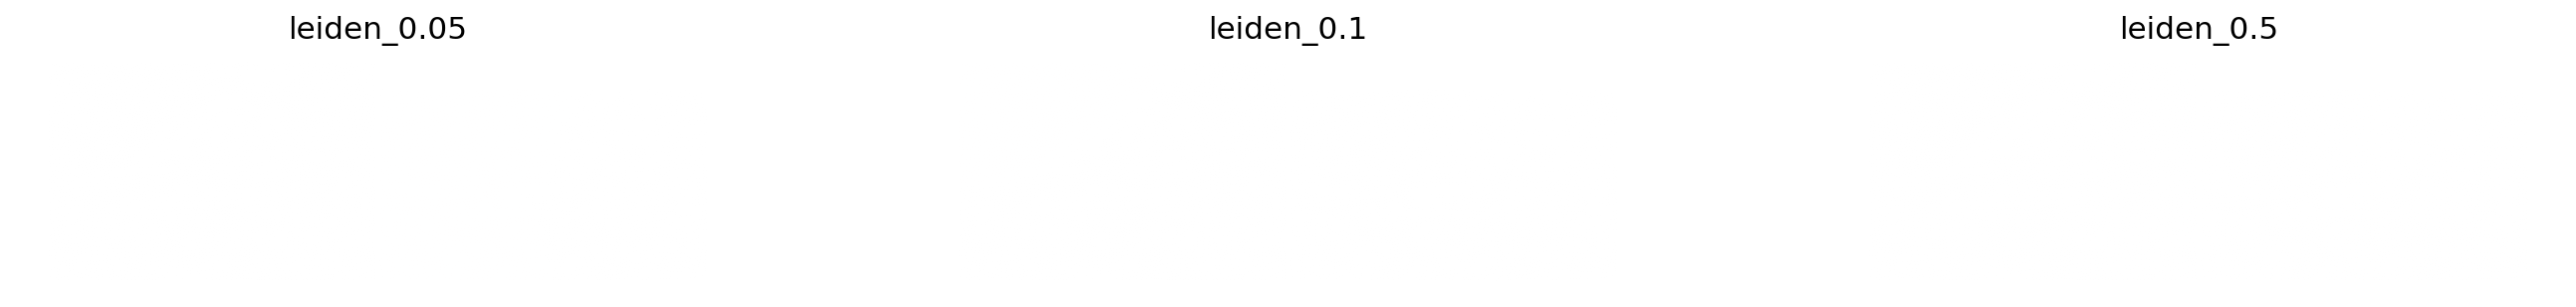

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 3: 0 hours, 2 minutes and 32 seconds.


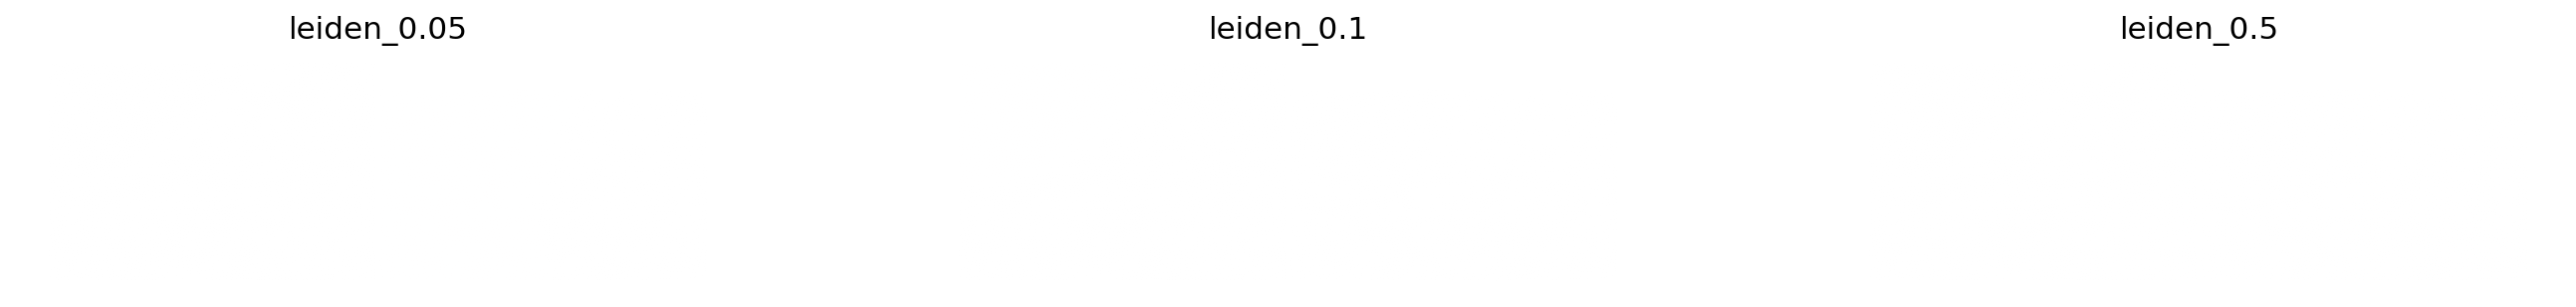

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 4: 0 hours, 2 minutes and 27 seconds.


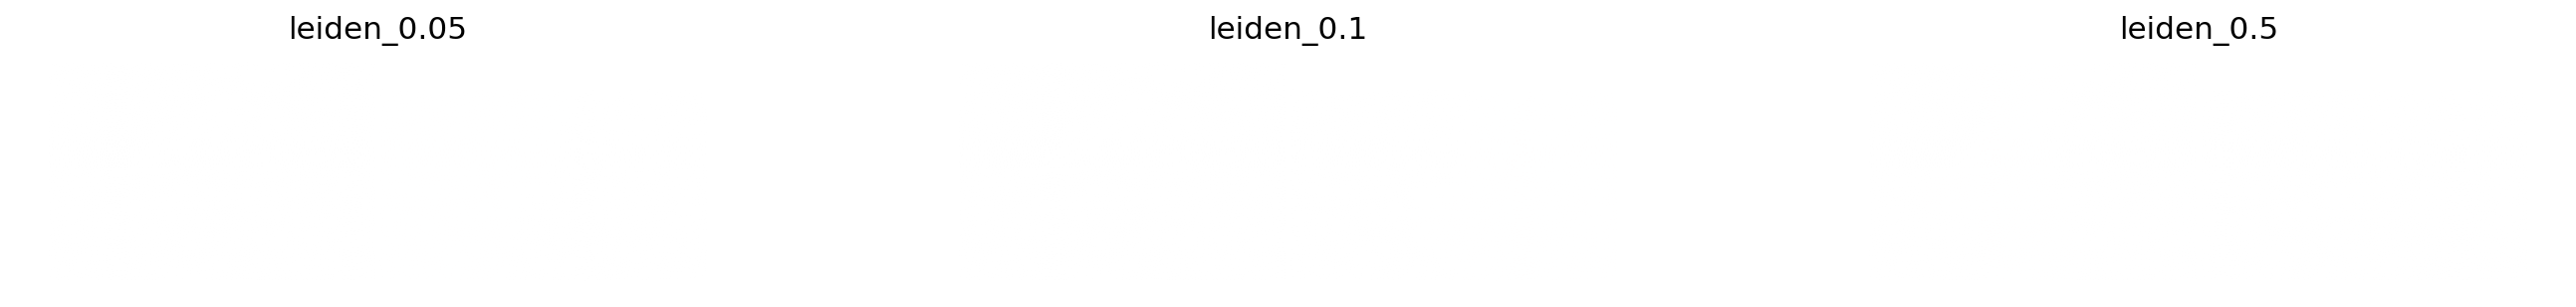

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 5: 0 hours, 2 minutes and 30 seconds.


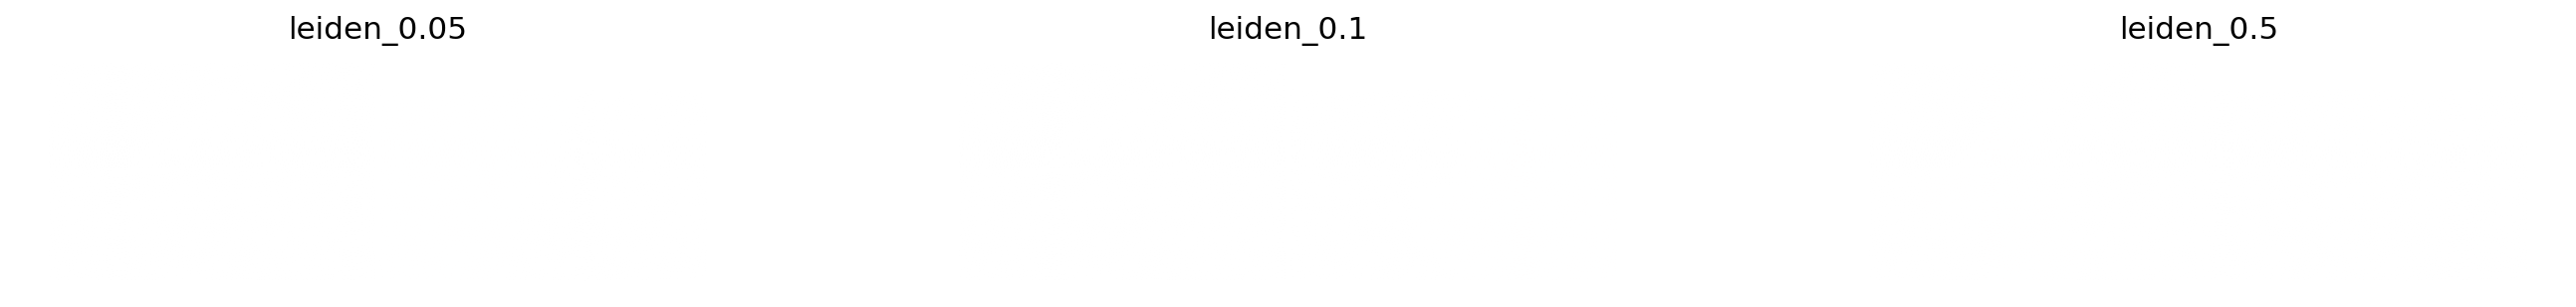

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 6: 0 hours, 2 minutes and 28 seconds.


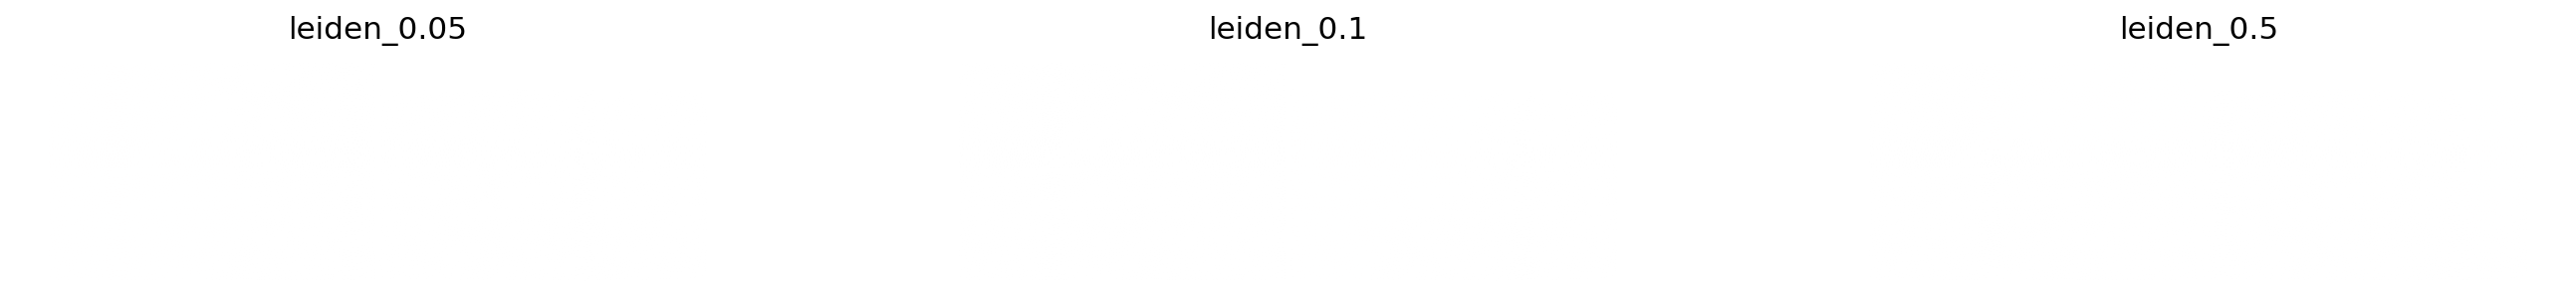

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 7: 0 hours, 2 minutes and 28 seconds.


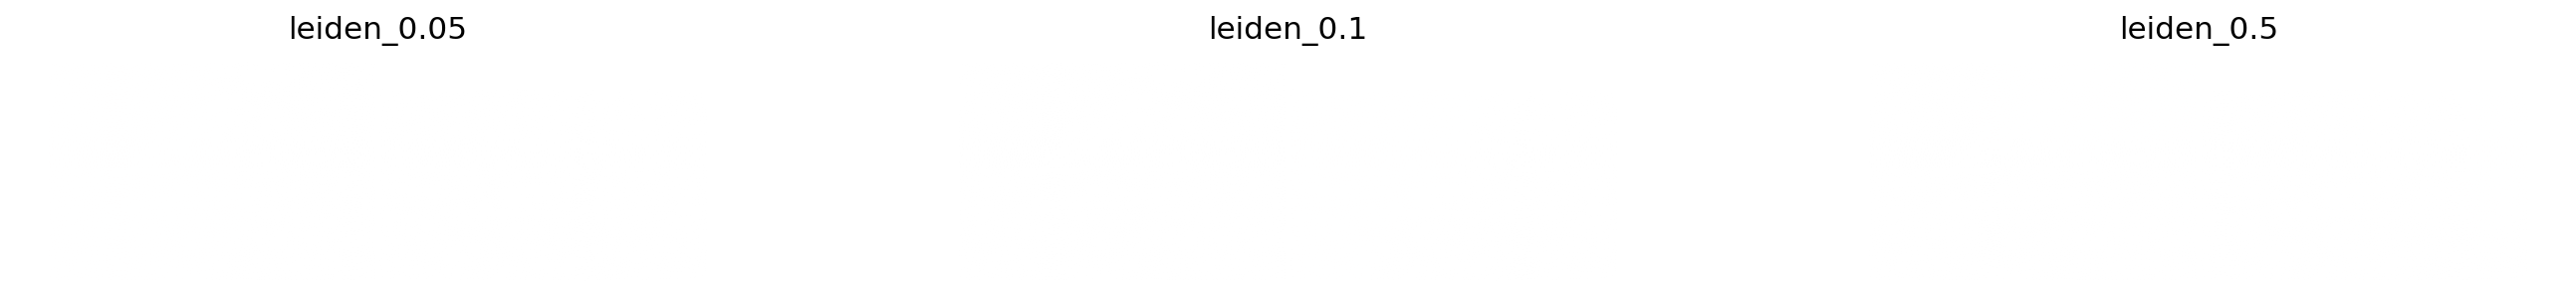

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 8: 0 hours, 2 minutes and 29 seconds.


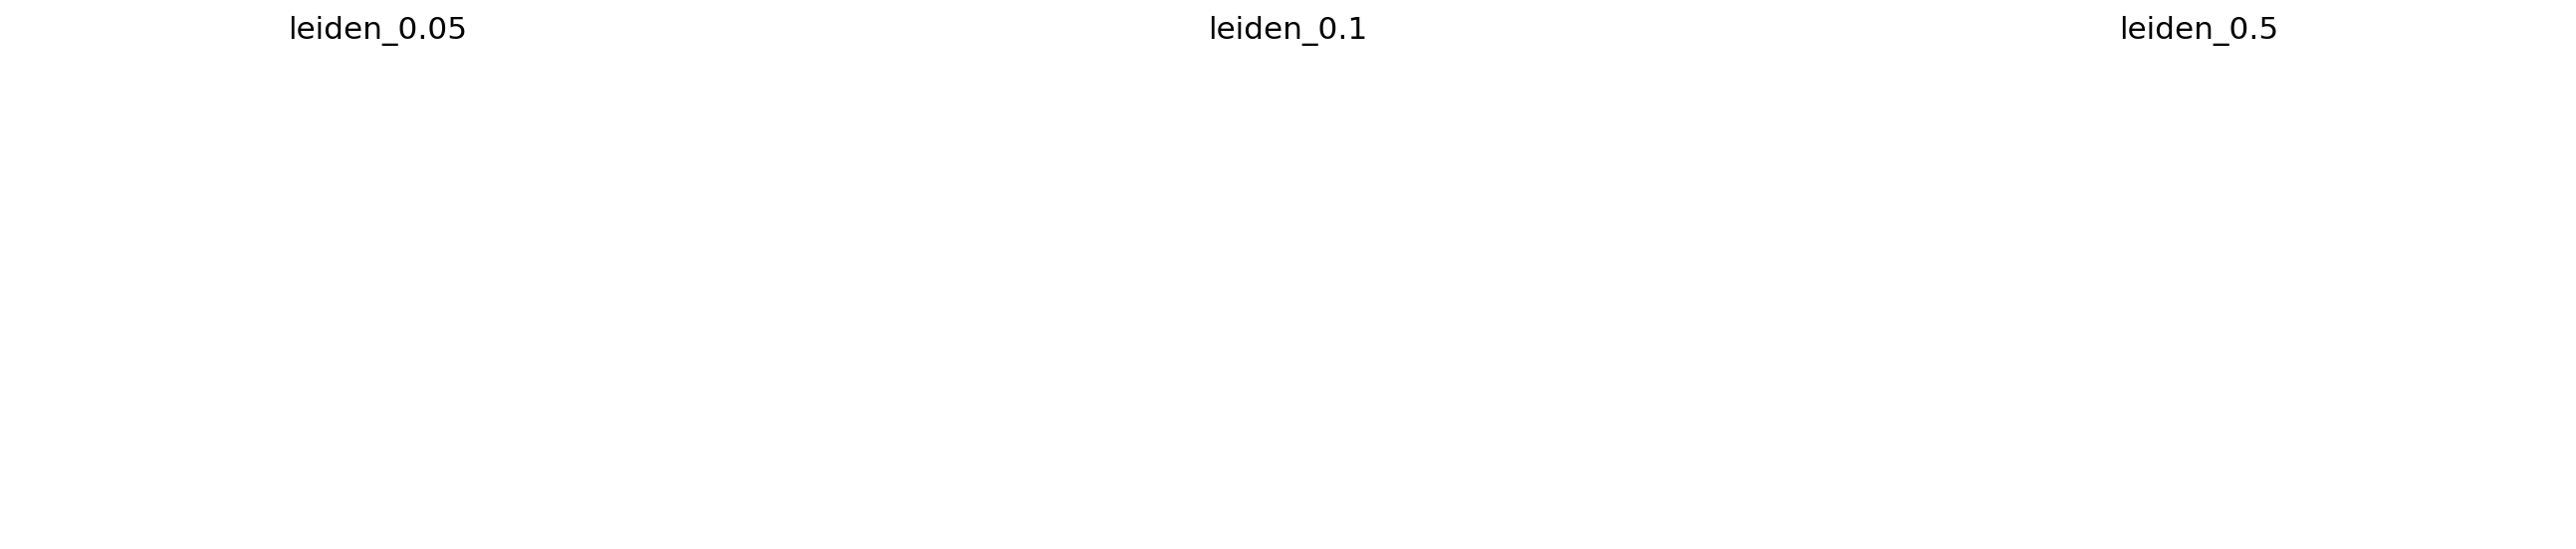

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 1: 0 hours, 1 minutes and 24 seconds.


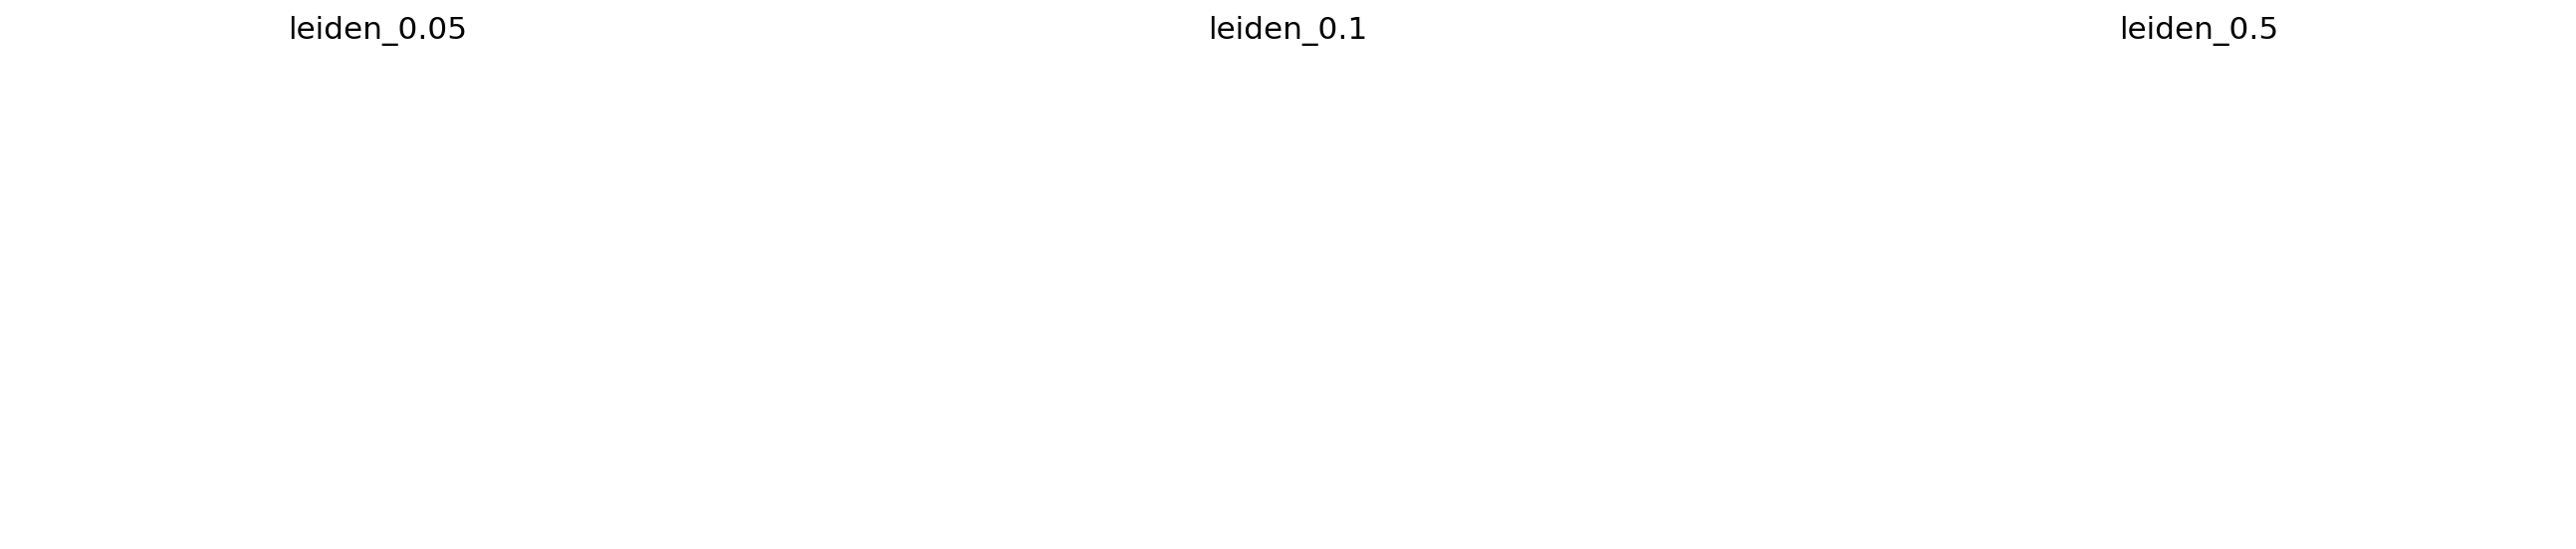

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 2: 0 hours, 1 minutes and 24 seconds.


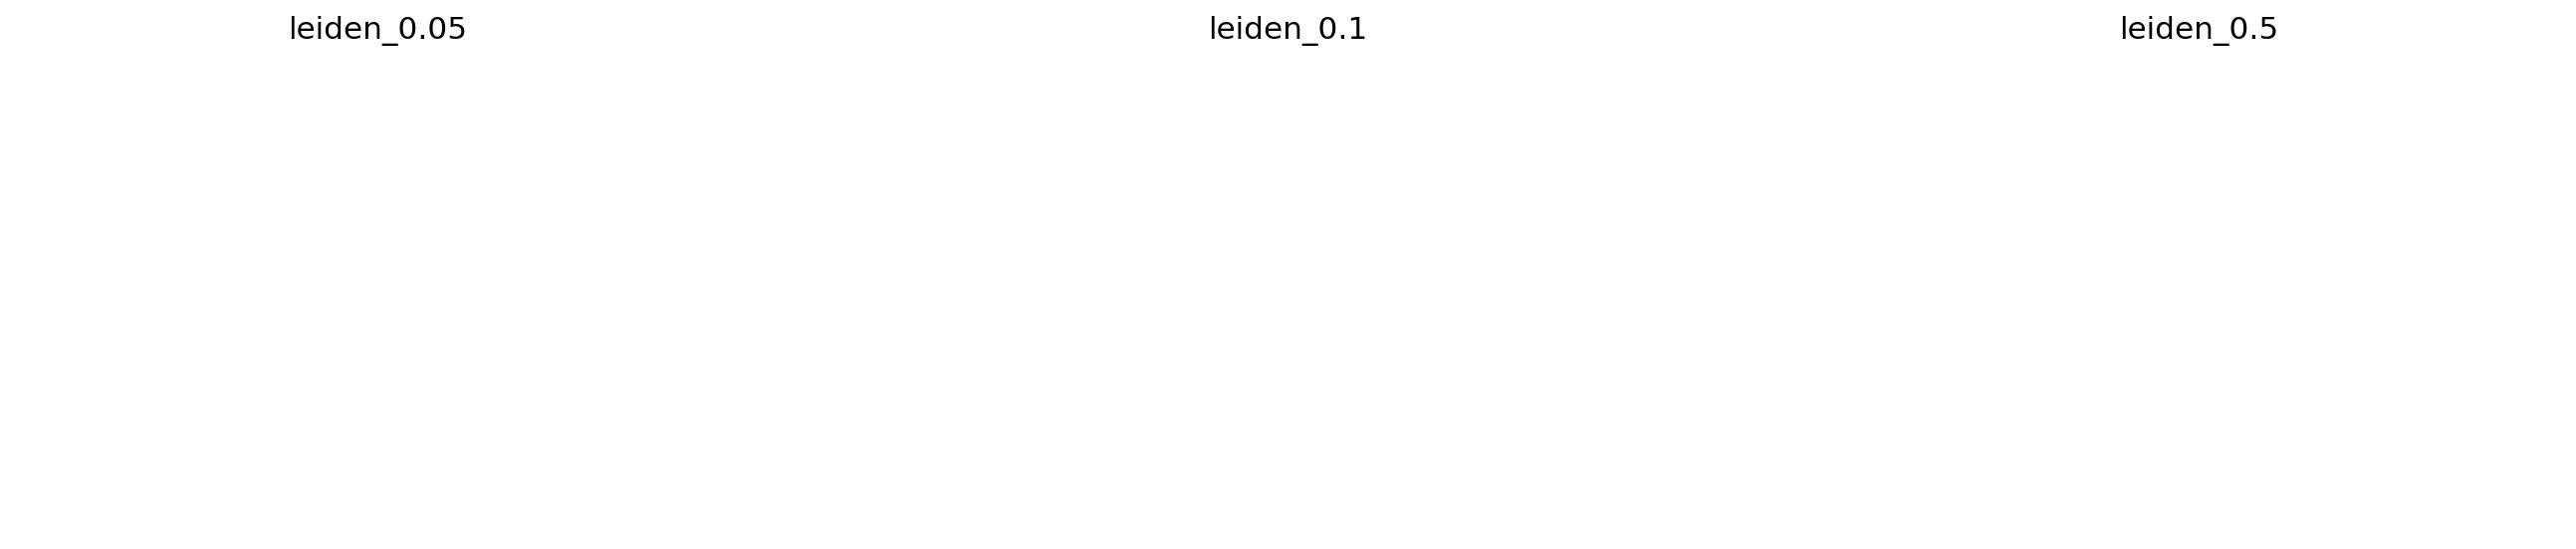

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 3: 0 hours, 1 minutes and 24 seconds.


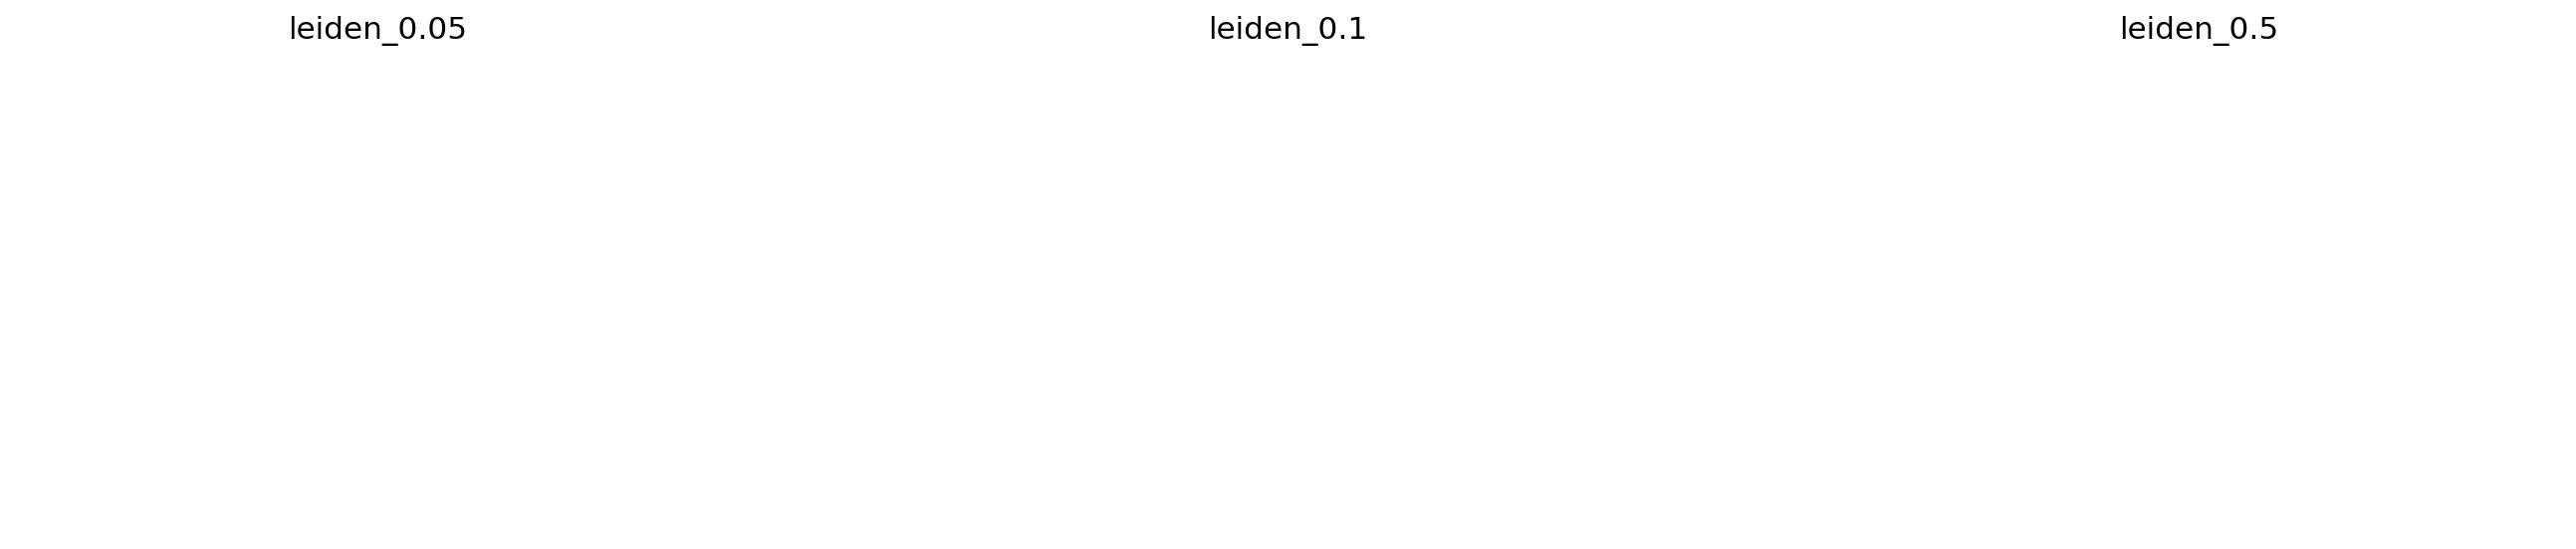

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 4: 0 hours, 1 minutes and 25 seconds.


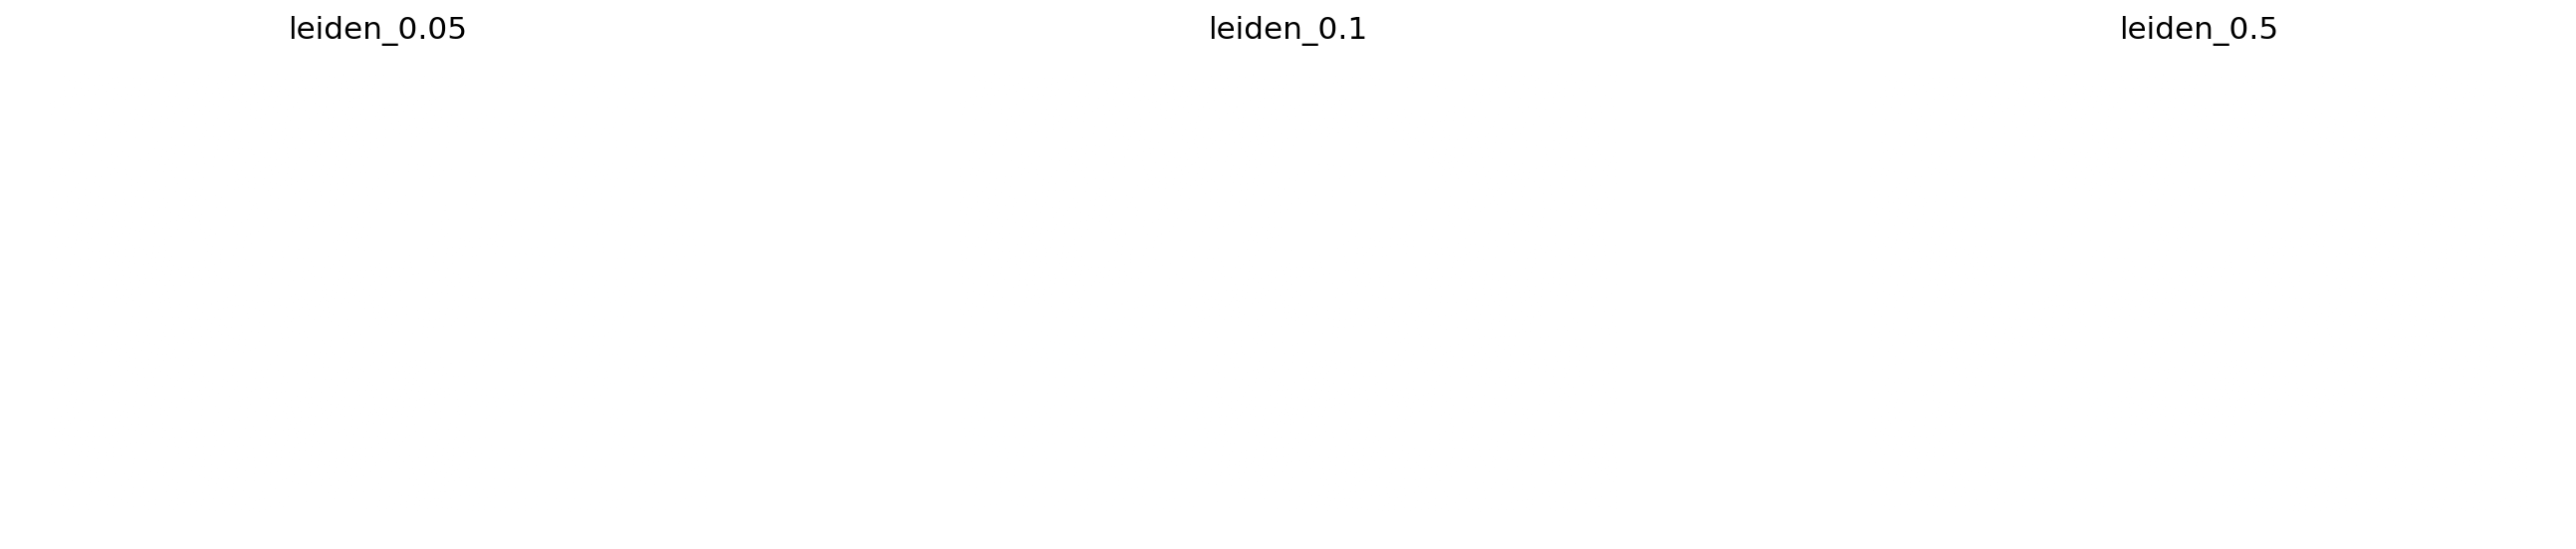

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 5: 0 hours, 1 minutes and 23 seconds.


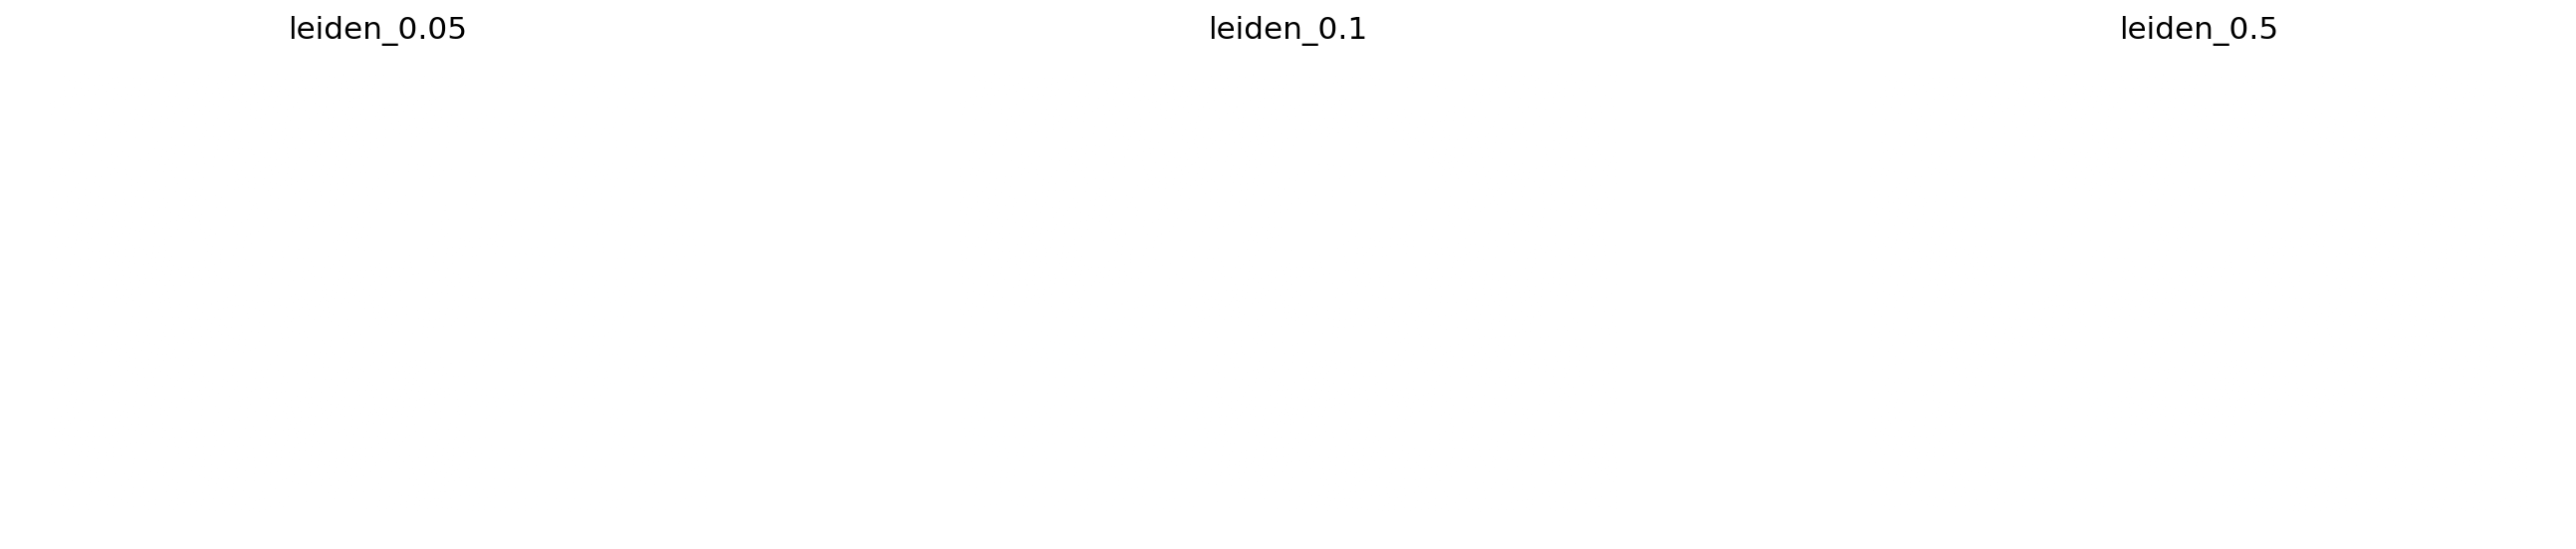

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 6: 0 hours, 1 minutes and 22 seconds.


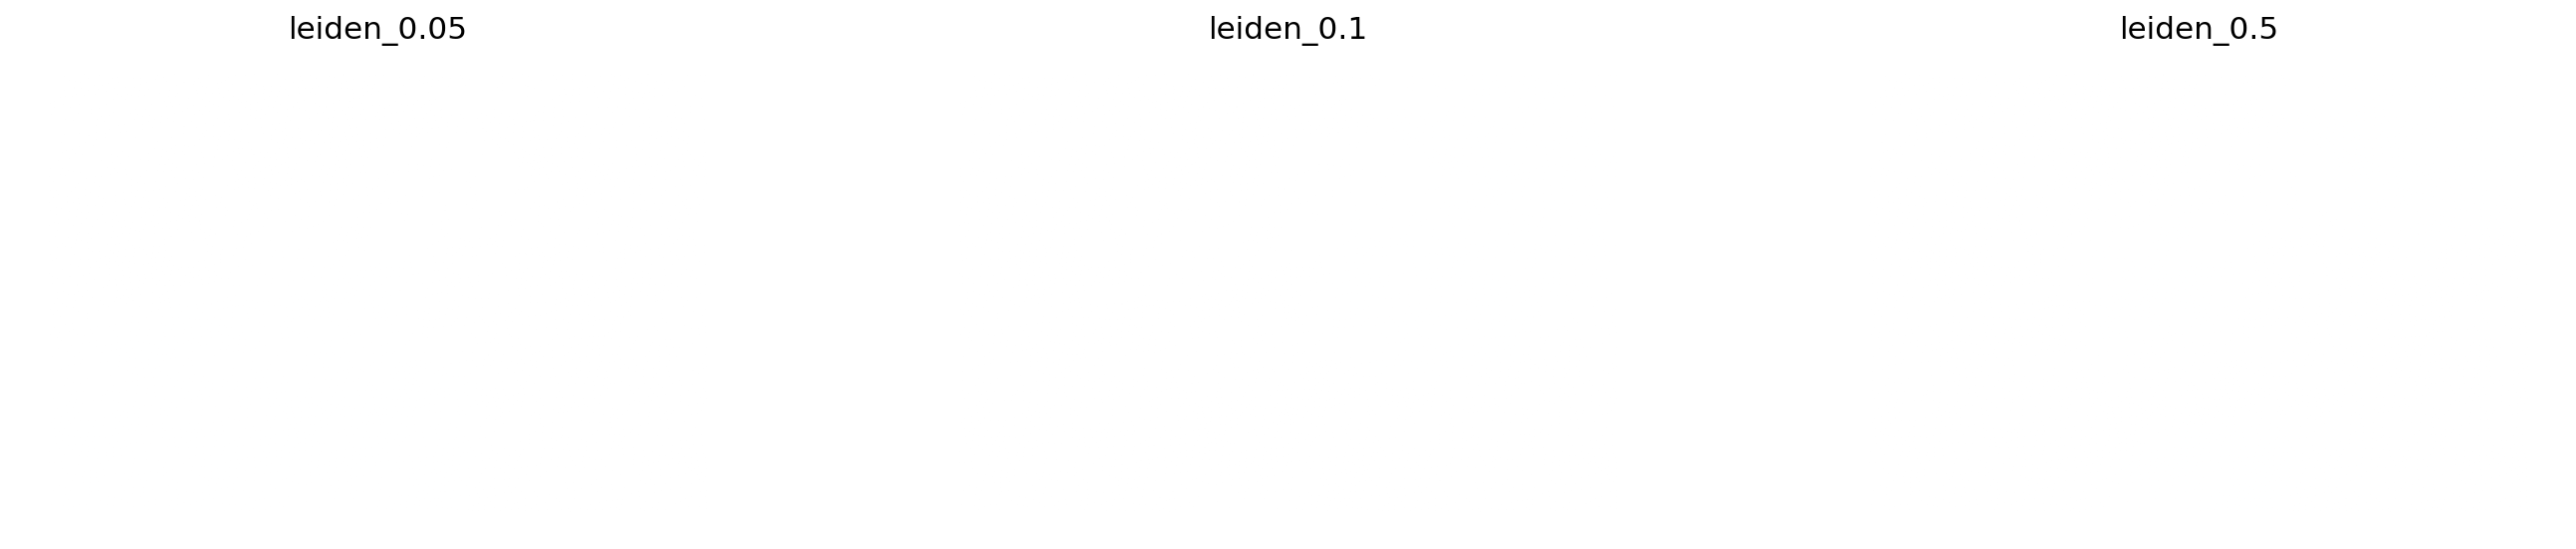

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 7: 0 hours, 1 minutes and 22 seconds.


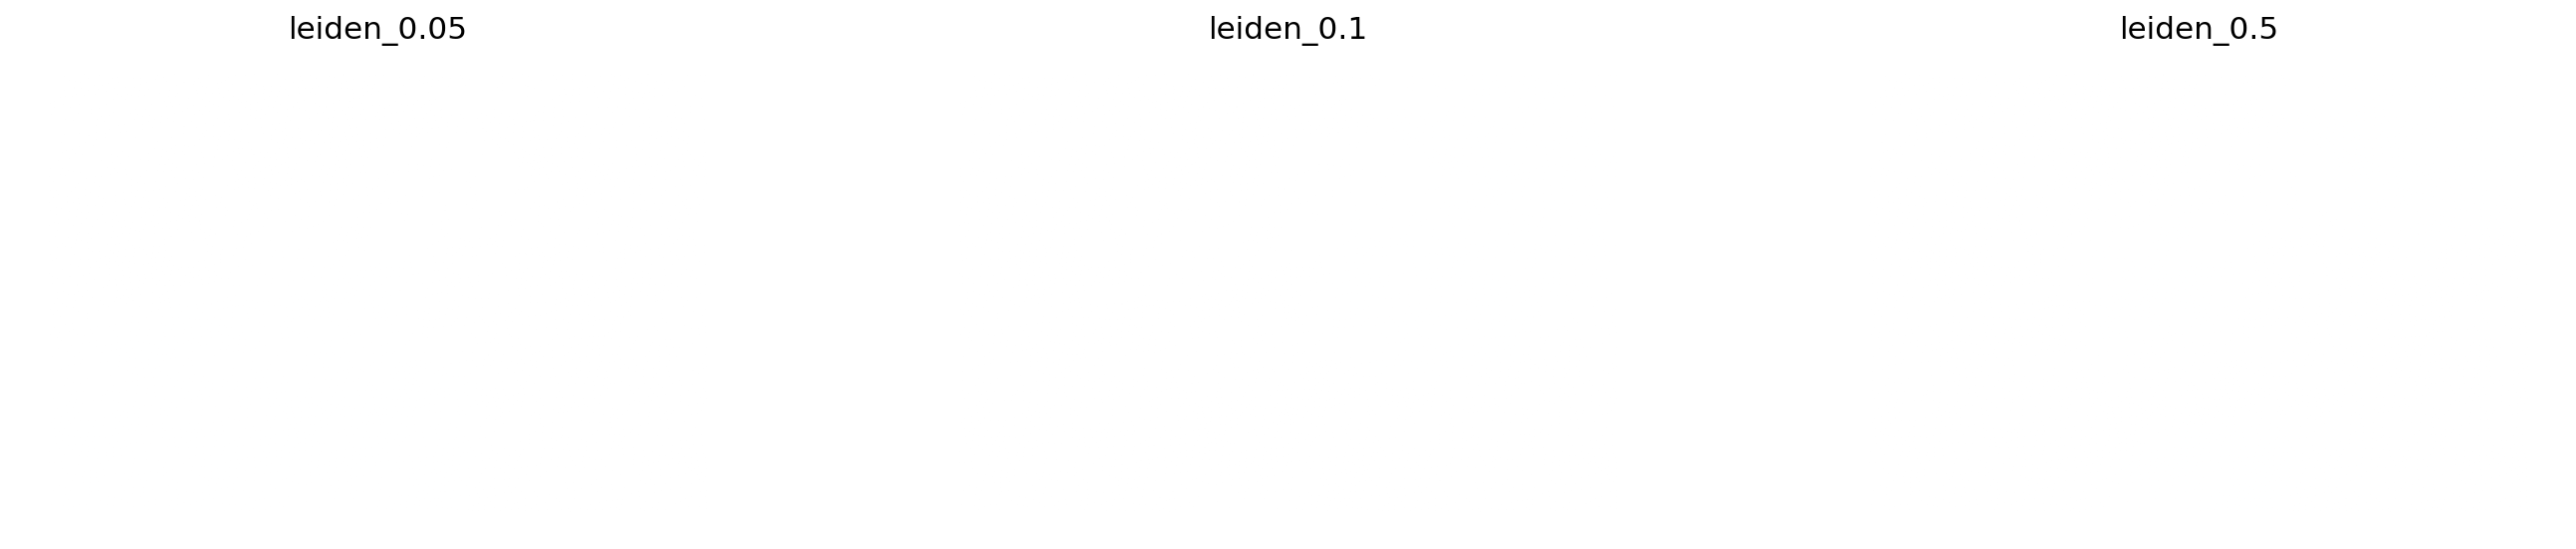

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 8: 0 hours, 1 minutes and 21 seconds.


/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


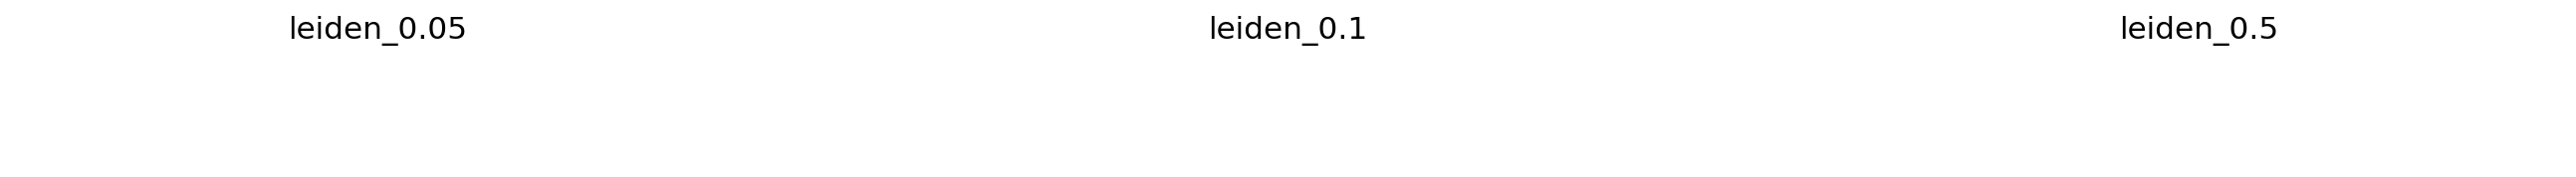

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 1: 0 hours, 0 minutes and 40 seconds.


/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


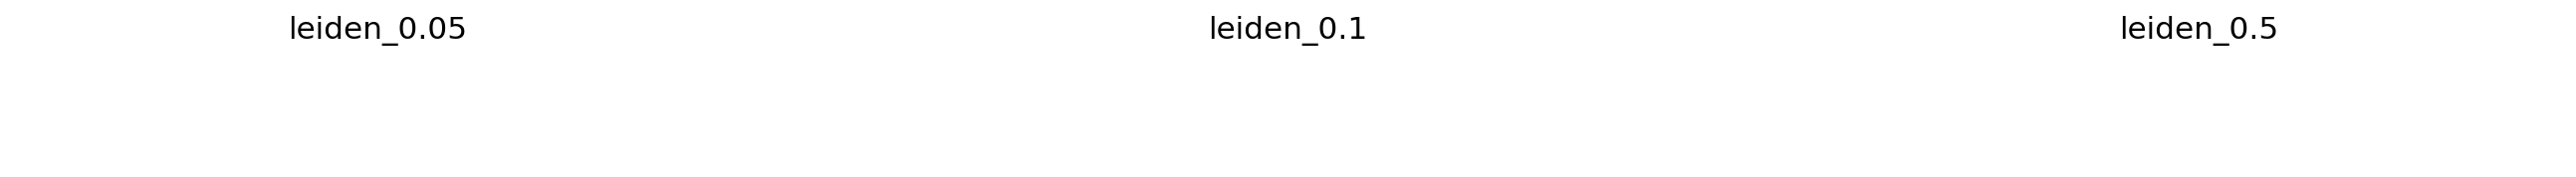

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 2: 0 hours, 0 minutes and 41 seconds.


/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


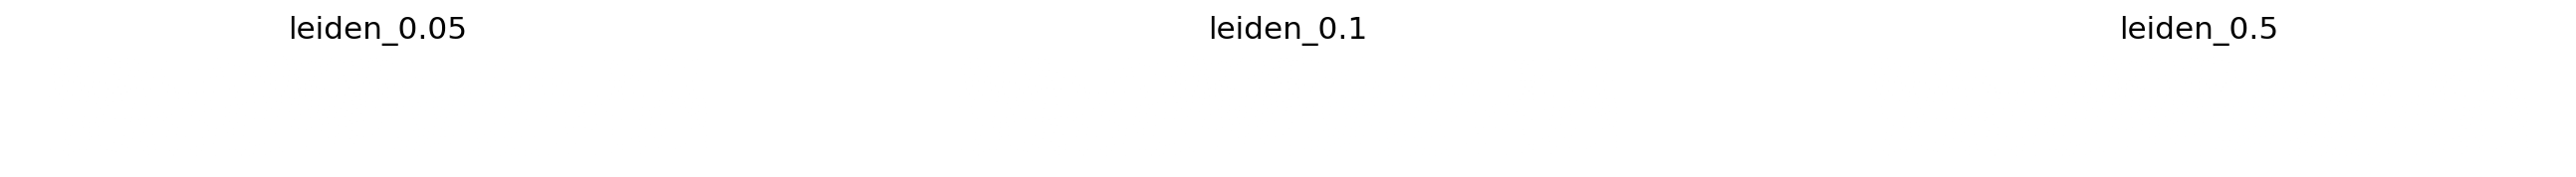

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 3: 0 hours, 0 minutes and 40 seconds.


/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


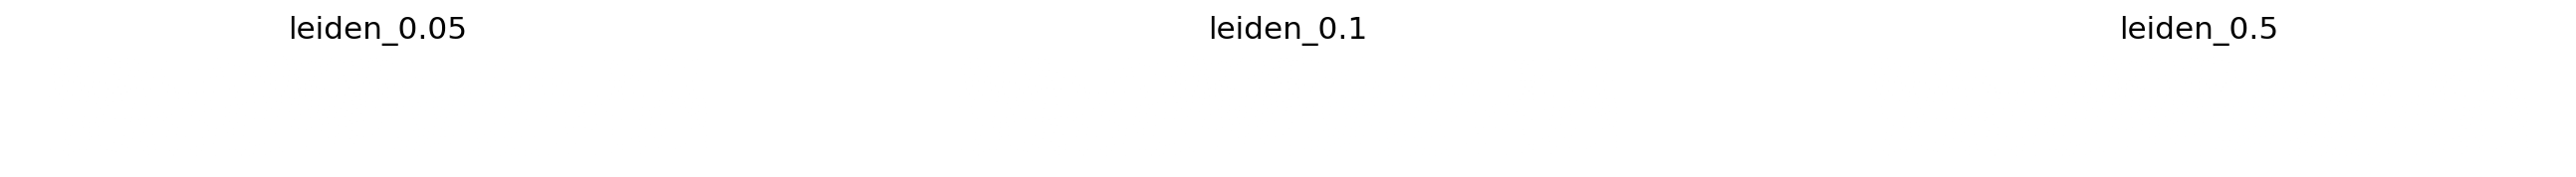

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 4: 0 hours, 0 minutes and 39 seconds.


/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


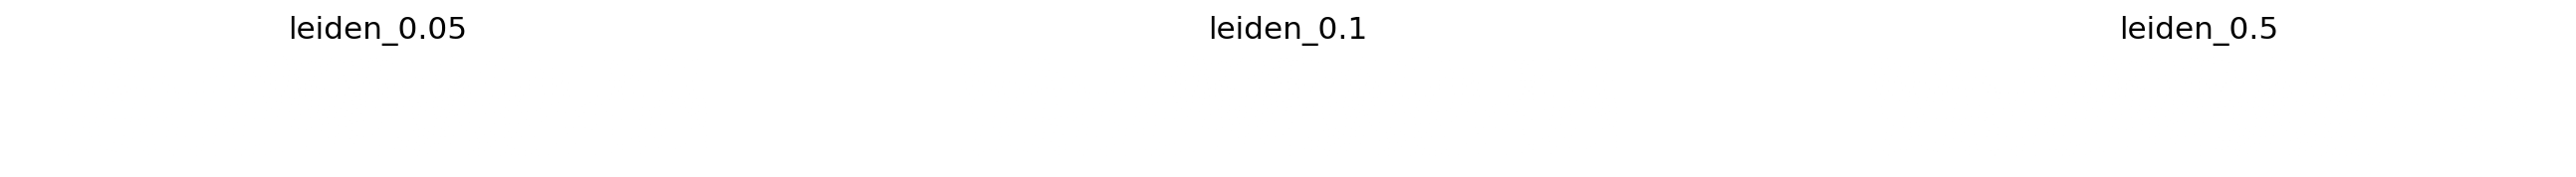

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 5: 0 hours, 0 minutes and 41 seconds.


/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


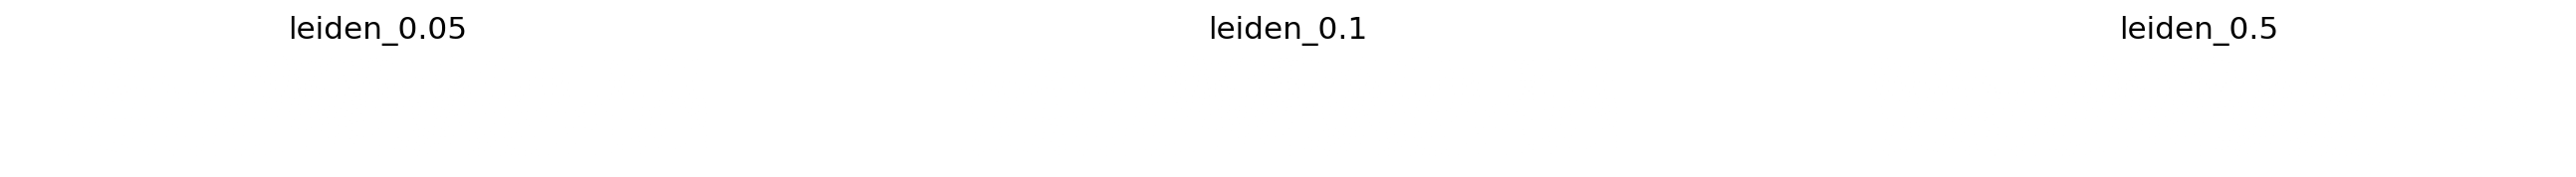

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 6: 0 hours, 0 minutes and 40 seconds.


/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


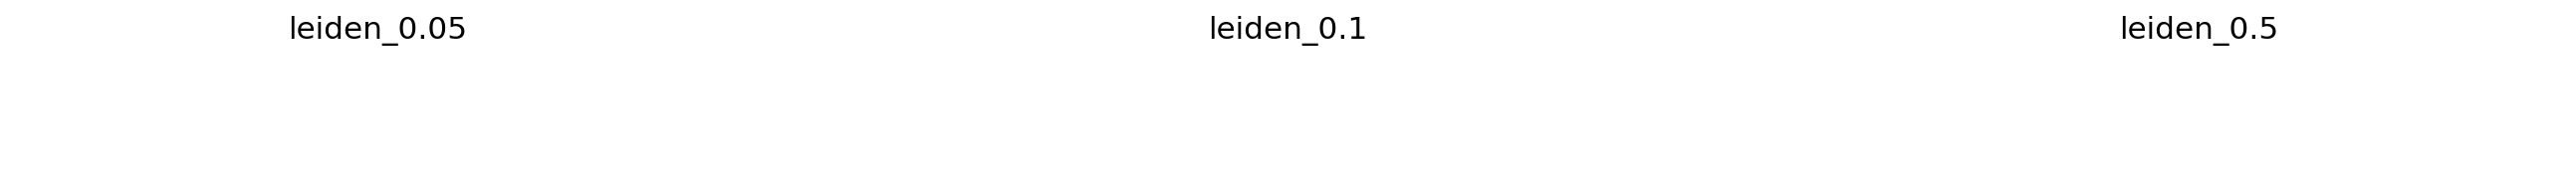

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 7: 0 hours, 0 minutes and 39 seconds.


/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


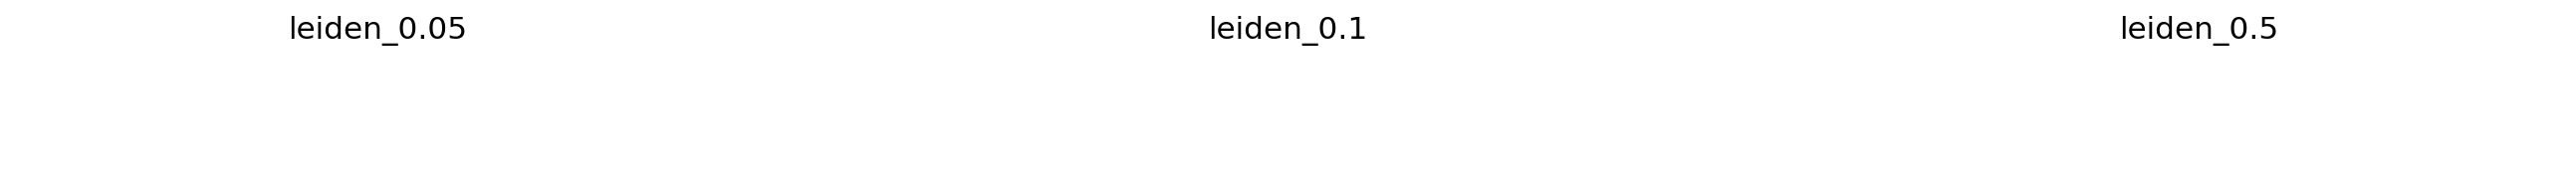

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/li

Duration of model training in run 8: 0 hours, 0 minutes and 37 seconds.


In [8]:
for subsample_pct in [10, 5, 1]: # 50, 25 pct out of memory
    train_sagenet_models(dataset=f"nanostring_cosmx_human_nsclc_subsample_{subsample_pct}pct_batch5",
                         cell_type_key="cell_type",
                         adata_new=None,
                         n_start_run=1,
                         n_end_run=8,
                         n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16])

In [ ]:
# This does not work because of memory exhaustion
# (Tesla V100-SXM3-32GB GPU)
train_sagenet_models(dataset="vizgen_merfish_mouse_liver",
                     cell_type_key="Cell_Type",
                     adata_new=None,
                     n_start_run=1,
                     n_end_run=10,
                     n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16])

In [ ]:
# ~10% sample of the original dataset
train_sagenet_models(dataset="vizgen_merfish_mouse_liver_sample",
                     cell_type_key="Cell_Type",
                     adata_new=None,
                     n_start_run=1,
                     n_end_run=10,
                     n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20])

In [ ]:
# ~20% sample of the original dataset
train_sagenet_models(dataset="nanostring_cosmx_human_nsclc_sample",
                     cell_type_key="cell_type",
                     adata_new=None,
                     n_start_run=1,
                     n_end_run=10,
                     n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20])

In [ ]:
train_sagenet_models(dataset="slideseqv2_mouse_hippocampus",
                     cell_type_key="cell_type",
                     adata_new=None,
                     n_start_run=1,
                     n_end_run=8,
                     n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16])